In [1]:
!pip install pandas-plink limix-lmm

In [2]:
import numpy as np
import pdb 
from pandas_plink import read_plink 
from limix_lmm import LMM
import pylab as plt
import os
import pandas as pd

In [3]:
import scipy
import scipy.stats as st
if not hasattr(scipy, 'dot'): scipy.dot = np.dot
if not hasattr(scipy, 'einsum'): scipy.einsum = np.einsum
if not hasattr(scipy, 'log'): scipy.log = np.log
if not hasattr(scipy, 'sign'): scipy.sign = np.sign
if not hasattr(scipy, 'sqrt'): scipy.sqrt = np.sqrt

In [4]:
!wget -O ALL.chr22_GRCh38.genotypes.20170504.zip "https://www.dropbox.com/s/86fdj3i7ir3vap7/ALL.chr22_GRCh38.genotypes.20170504.zip?dl=1"

--2026-02-17 22:04:37--  https://www.dropbox.com/s/86fdj3i7ir3vap7/ALL.chr22_GRCh38.genotypes.20170504.zip?dl=1
Auflösen des Hostnamens www.dropbox.com (www.dropbox.com)… 2620:100:6022:18::a27d:4212, 162.125.66.18
Verbindungsaufbau zu www.dropbox.com (www.dropbox.com)|2620:100:6022:18::a27d:4212|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 302 Found
Platz: https://www.dropbox.com/scl/fi/2j079oew31gwd2hzajlil/ALL.chr22_GRCh38.genotypes.20170504.zip?rlkey=7307x4sjq9lkvhwu3aivh5uut&dl=1 [folgend]
--2026-02-17 22:04:38--  https://www.dropbox.com/scl/fi/2j079oew31gwd2hzajlil/ALL.chr22_GRCh38.genotypes.20170504.zip?rlkey=7307x4sjq9lkvhwu3aivh5uut&dl=1
Wiederverwendung der bestehenden Verbindung zu [www.dropbox.com]:443.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 302 Found
Platz: https://uc1c8c3ef461f892b35433bd646c.dl.dropboxusercontent.com/cd/0/inline/C7GJchADYbPU5npqzmgiyETuK73Tm8cVU3NY9Eqn0jku2N6BPgBzV0mI0YUmPr9RvXGh4agK-E_8-CeSwx4w3D3KUxVbBKJyK3BHQ

In [5]:
!unzip -o -q ALL.chr22_GRCh38.genotypes.20170504.zip && rm ALL.chr22_GRCh38.genotypes.20170504.zip

In [6]:
bfile = 'ALL.chr22_GRCh38.genotypes.20170504' 
bim, fam, G = read_plink(bfile)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 26.58it/s]
/opt/miniconda3/envs/i2dl/lib/python3.11/site-packages/pandera/_pandas_deprecated.py:146: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


print(len(bim))

G = G.compute()

snp_missing = np.mean(np.isnan(G), axis=1)  
keep_missing = snp_missing < 0.01           # missing rate > 0.01 (0.02, or 0.05) -> remove SNPs, that are missing in more than 1% of individuals

G = G[keep_missing, :]
bim = bim.loc[keep_missing].copy()
print(len(bim))
bim.reset_index(drop=True, inplace=True)
bim['i'] = np.arange(len(bim))

keep_unique = ~bim['snp'].duplicated()     # removing duplicated 
print(len(bim))

allele_freq = np.nanmean(G, axis=1) / 2.0     # Calculate allele frequency (values are 0, 1, 2 -> divide by 2)
maf = np.minimum(allele_freq, 1 - allele_freq)

keep_maf = maf > 0.02  # maf < 0.01 
print(len(bim))


filtered = keep_maf & keep_unique.values

G = G[filtered, :]
bim = bim.loc[filtered].copy()

bim.reset_index(drop=True, inplace=True)
bim['i'] = np.arange(len(bim))

print(len(bim))

In [7]:
bfile = 'data/chr22_step3_sampleqc'
bim, fam, G = read_plink(bfile)

Mapping files: 100%|██████████| 3/3 [00:00<00:00, 35.87it/s]


In [8]:
n_snps = bim.shape[0]
n_samples = fam.shape[0]
n_snps, n_samples

(59743, 2504)

In [291]:
def extract_region(bim, G, chrom, start, end): 
    I1 = bim['chrom']==str(chrom)
    I2 = bim['pos'] > start
    I3 = bim['pos'] < end
    Ikeep = I1 * I2 * I3
    bim = bim.loc[Ikeep].copy()
    G = G[bim['i'].values] 
    bim['i'] = np.arange(len(bim)) 
    return bim, G

In [292]:
def subset_individuals(fam, G, keep_idxs): 
    fam = fam.iloc[keep_idxs]
    G = G[:, keep_idxs]
    return bim, G

In [293]:
N = 1000
np.random.seed(0)
idxs = np.sort(np.random.permutation(fam.shape[0])[:N]) 
fams, Gs = subset_individuals(bim, G, idxs)

In [294]:
chrom = 22
start = 30797531
size = 100000
bimr, Gr = extract_region(bim, Gs, chrom, start, start + size)

In [9]:
X_real = G.compute().T

In [11]:
mu_full = X_real.mean(axis=0)
sd_full = X_real.std(axis=0, ddof=0)
keep_full = sd_full > 1e-12
keep_idx  = np.where(keep_full)[0] 
standardized_X = (X_real[:, keep_full] - mu_full[keep_full]) / sd_full[keep_full]

In [12]:
# bim data for variants that werent dropped after the standardization
bim_kept = bim.iloc[keep_idx].copy().reset_index(drop=True)

bim_kept["orig_bim_idx"] = keep_idx

In [16]:
standardized_X[:,4]
standardized_X.shape

(2504, 59740)

In [17]:
def simulate_pheno(X, idx_caus, var_expl, rng, direction=None):
    # Ensure that the number of causal variant indices matches the number of variances explained.
    assert len(idx_caus) == len(var_expl)

    # If no direction is provided, randomly assign a positive or negative direction for each causal variant.
    if direction is None:
        direction = 2. * (rng.random(len(idx_caus)) > 0.5) - 1.
    # Ensure that the number of directions matches the number of causal variant indices.
    assert len(idx_caus) == len(direction)

    # Compute the remaining variance after accounting for the variance explained by the causal variants.
    ve = 1 - var_expl.sum()
    # Ensure that the total variance explained by causal variants is less than 1.
    assert ve > 0, 'sum(var_expl) should be < 1'

    # Compute the effect sizes for the causal variants based on the variance they explain and their direction.
    beta = np.sqrt(var_expl) * direction

    # Extract the columns of X corresponding to the causal variants and standardize them.
    Xc = X[:, idx_caus]
    Xc = (Xc - Xc.mean(0)) / Xc.std(0)

    # Compute the genetic component of the phenotype.
    yg = Xc.dot(beta)[:, None]
    # Compute the noise component of the phenotype.
    yn = np.sqrt(ve) * rng.standard_normal((X.shape[0], 1))

    # Sum the genetic and noise components to get the simulated phenotype.
    y = yg + yn

    # Initialize the real effect sizes for all variants in X as zeros.
    beta_real = np.zeros(X.shape[1])
    # Update the real effect sizes for the causal variants.
    beta_real[idx_caus] = beta

    # Standardize the phenotypic values to have mean 0 and standard deviation 1.
    ystd = y.std()
    y = (y - y.mean()) / ystd
    # Adjust the real effect sizes accordingly after standardizing y.
    beta_real = beta_real / ystd

    return y, beta_real

In [18]:
def qq_plot(p_values, title):
    """
    Create a QQ plot given a list of p-values.

    Parameters:
    - p_values: list of p-values
    - title: title for the plot
    """

    # Sort p-values
    observed = -np.log10(np.sort(p_values))
    expected = -np.log10(np.arange(1, len(p_values) + 1) / (len(p_values) + 2))

    # Create the QQ plot
    plt.scatter(expected, observed, marker='.')
    plt.plot([0, max(expected)], [0, max(expected)], color='red', linestyle='--')
    plt.xlabel('Expected -log10(P-value)')
    plt.ylabel('Observed -log10(P-value)')
    plt.title(title)

In [19]:
n_causal = 10
h2 = 0.6

rng = np.random.default_rng(42)
idx_caus = rng.choice(standardized_X.shape[1], size=n_causal, replace=False)
var_expl = np.repeat(h2/n_causal, n_causal)

In [20]:
y, beta_real = simulate_pheno(standardized_X, idx_caus, var_expl, rng)

In [21]:
pheno = fam[["fid","iid"]].copy()
pheno.columns = ["FID","IID"]
pheno["y"] = y.reshape(-1)

In [22]:
pcs = pd.read_csv("chr22_pca.eigenvec", sep=r"\s+", header=None, engine="python")
pcs.columns = ["FID","IID"] + [f"PC{i}" for i in range(1, pcs.shape[1]-1)]

df = pheno.merge(pcs, on=["FID","IID"], how="inner", validate="one_to_one")

In [321]:
k = 10
F = np.column_stack([np.ones((df.shape[0], 1)),
                     df[[f"PC{i}" for i in range(1, k+1)]].to_numpy()])

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(standardized_X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape

((1752, 59740), (752, 59740), (1752, 1))

In [25]:
# Perform genetic association testing
F = np.ones_like(y_train)
lmm = LMM(y_train, F)
lmm.process(X_train)
pv = lmm.getPv()
beta = lmm.getBetaSNP() 
beta_ste = lmm.getBetaSNPste()

In [26]:
pv.shape

(59740,)

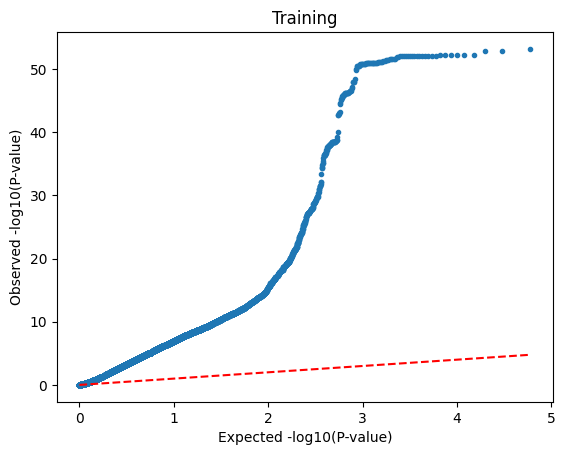

In [27]:
qq_plot(pv,"Training")
plt.show()

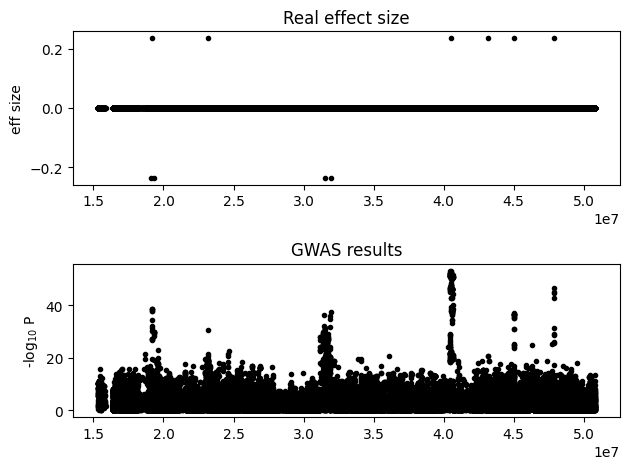

In [28]:
# Plot ground truth and results
x = bim_kept['pos'].values 
plt.subplot(211) 
plt.title('Real effect size') 
plt.plot(x, beta_real, '.k') 
plt.ylabel('eff size') 
plt.subplot(212) 
plt.title('GWAS results') 
plt.plot(x, -np.log10(pv), '.k') 
plt.ylabel('-log$_{10}$ P') 
plt.tight_layout()
plt.show()

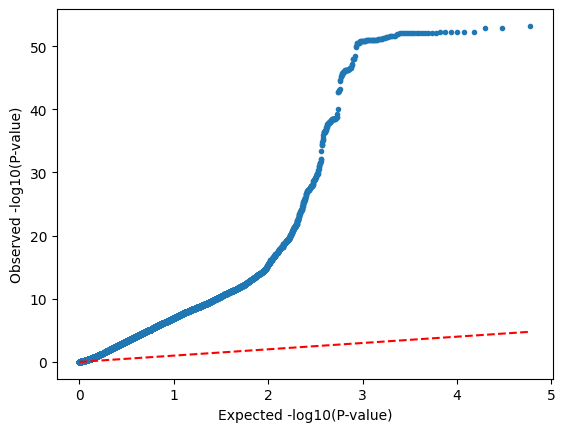

In [29]:
qq_plot(pv,"")
plt.show()

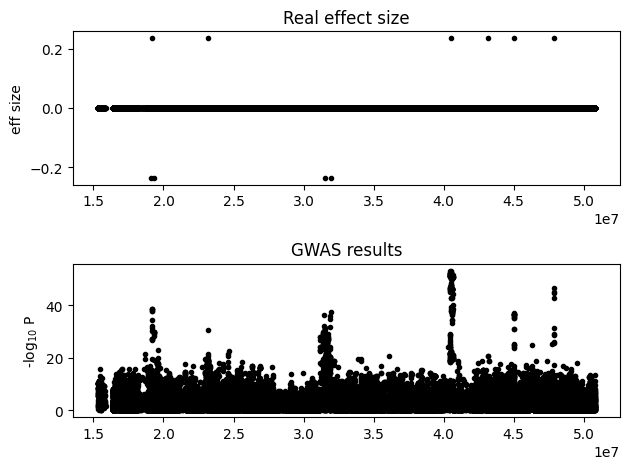

In [30]:
x = bim_kept['pos'].values
plt.subplot(211)
plt.title('Real effect size')
plt.plot(x, beta_real, '.k')
plt.ylabel('eff size')
plt.subplot(212)
plt.title('GWAS results')
plt.plot(x, -np.log10(pv), '.k')
plt.ylabel('-log$_{10}$ P')
plt.tight_layout()
plt.show()

In [31]:
df_plink = pd.DataFrame({
    'SNP': bim_kept['snp'].astype(str), 
    'P': pv
})

df_plink.to_csv("gwas.assoc", sep="\t", index=False)

plink --bfile  chr22_step3_sampleqc \                     ### The LD reference panel
         --clump gwas.assoc \                             ### Your summary stats file
         --clump-p1 5e-8 \                                ### Significance threshold for index SNPs
         --clump-p2 0.05 \                                ### Secondary significance threshold for clumped SNPs
         --clump-r2 0.1 \                                ### LD threshold for clumping
         --clump-kb 500 \
         --out chr22_GWAS_clumped_r0.1

         Options in effect:
  --bfile data/chr22_step3_sampleqc
  --clump gwas.assoc
  --clump-kb 250
  --clump-p1 1
  --clump-p2 1
  --clump-r2 0.1
  --out chr22_GWAS_clumped_r0.1

In [32]:
clumped = pd.read_csv("chr22_clumped.clumped", sep=r"\s+", engine="python")
clumped.head()
len(clumped)
lead_snps = clumped["SNP"].astype(str).tolist()
lead_snps
len(lead_snps)
is_clumped = clumped['SNP'].values

In [34]:
snp_ids = bim_kept['snp'].values  
mask = np.isin(snp_ids, is_clumped)

In [35]:
X_clump_train = X_train[:, mask] 
X_clump_test = X_test[:, mask]   

beta_clump = beta[mask]

In [36]:
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import r2_score
import scipy.stats as st
from sklearn import linear_model
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import spearmanr

In [37]:
# Train linear model
model = LinearRegression(fit_intercept=False)
model.fit(X_clump_train, y_train)

# Predictions
y_pred_test = model.predict(X_clump_test)

# Evaluate
r2 = r2_score(y_test, y_pred_test)
rho, _ = spearmanr(y_test, y_pred_test)

print("R²:", r2)
print("Spearman r:", rho)

R²: 0.589442468736179
Spearman r: 0.7638334386622702


In [38]:
regr = linear_model.LinearRegression(fit_intercept=False)
regr.fit(X_clump_train, y_train)

y_pred = regr.predict(X_clump_test)

In [39]:
regr = linear_model.LinearRegression(fit_intercept=False)
regr.fit(X_clump_train, y_train)

y_pred = regr.predict(X_clump_test)

In [40]:
r2 = r2_score(y_test, y_pred)
rho, _ = spearmanr(y_test, y_pred)

print("R2", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("spearman r: ", rho)

R2 0.589442468736179
MSE: 0.42592138171322647
spearman r:  0.7638334386622702


0.6394963789431567
0.799685174892711


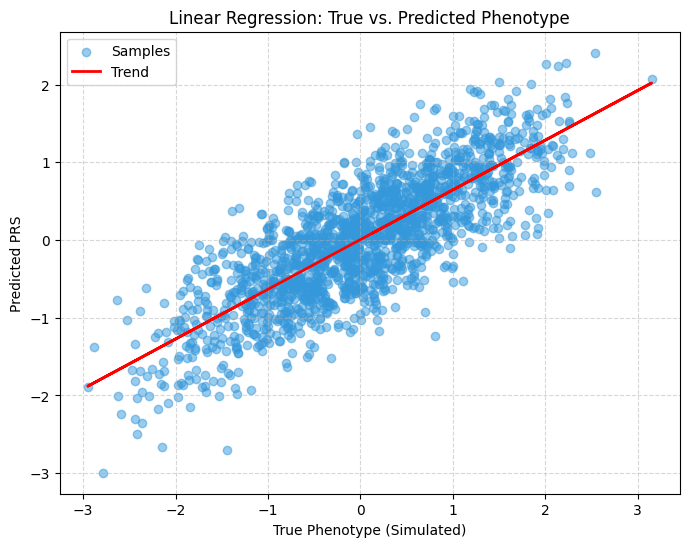

In [41]:
lin_reg = LinearRegression()
lin_reg.fit(X_clump_train, y_train.flatten())
y_pred_lin = lin_reg.predict(X_clump_train)
print(r2_score(y_train, y_pred_lin))
print(st.pearsonr(y_train.flatten(), y_pred_lin.flatten())[0])

plt.figure(figsize=(8, 6))

plt.scatter(y_train, y_pred_lin, alpha=0.5, color='#3498db', label='Samples')

m, b = np.polyfit(y_train.flatten(), y_pred_lin.flatten(), 1)
plt.plot(y_train, m*y_train + b, color='red', linewidth=2, label='Trend')

plt.title("Linear Regression: True vs. Predicted Phenotype")
plt.xlabel("True Phenotype (Simulated)")
plt.ylabel("Predicted PRS")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

Ridge Regression Corr:  0.7997


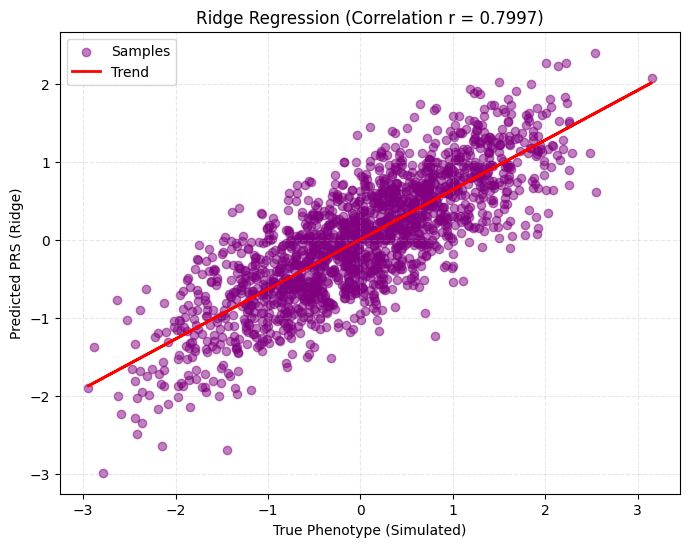

In [42]:
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(cv=5)
ridge.fit(X_clump_train, y_train.flatten())
y_pred_ridge = ridge.predict(X_clump_train)

print(f"Ridge Regression Corr:  {st.pearsonr(y_train.flatten(), y_pred_ridge.flatten())[0]:.4f}")

corr_ridge = st.pearsonr(y_train.flatten(), y_pred_ridge.flatten())[0]

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_pred_ridge, alpha=0.5, color='purple', label='Samples')

m, b = np.polyfit(y_train.flatten(), y_pred_ridge.flatten(), 1)
plt.plot(y_train, m*y_train + b, color='red', linewidth=2, label='Trend')

plt.title(f"Ridge Regression (Correlation r = {corr_ridge:.4f})")
plt.xlabel("True Phenotype (Simulated)")
plt.ylabel("Predicted PRS (Ridge)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

R2 Score:   0.5081
Correlation:0.7181


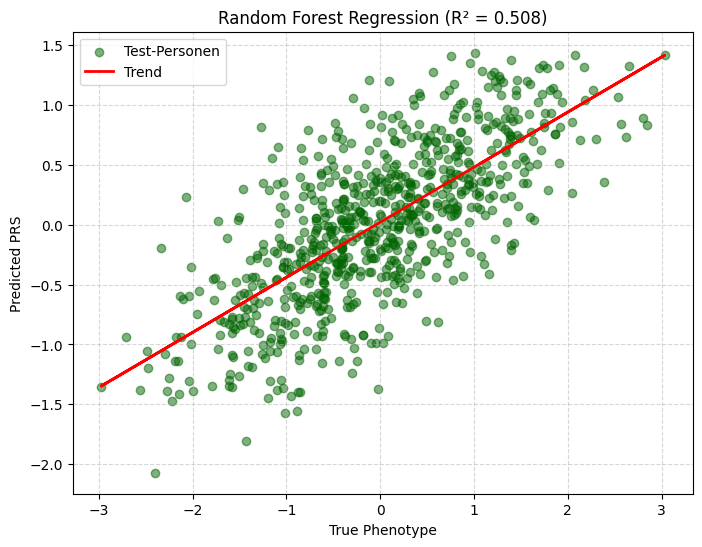

In [89]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import scipy.stats as st
import matplotlib.pyplot as plt
import numpy as np

rf_model = RandomForestRegressor(
    n_estimators=175, 
    max_depth=10,       
    random_state=42, 
    n_jobs=-1           
)

rf_model.fit(X_clump_train, y_train.flatten())

y_pred_rf = rf_model.predict(X_clump_test)

r2_rf = r2_score(y_test, y_pred_rf)
corr_rf = st.pearsonr(y_test.flatten(), y_pred_rf.flatten())[0]

print(f"R2 Score:   {r2_rf:.4f}")
print(f"Correlation:{corr_rf:.4f}")

plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred_rf, alpha=0.5, color='darkgreen', label='Test-Personen')

m, b = np.polyfit(y_test.flatten(), y_pred_rf.flatten(), 1)
plt.plot(y_test, m*y_test + b, color='red', linewidth=2, label='Trend')

plt.title(f"Random Forest Regression (R² = {r2_rf:.3f})")
plt.xlabel("True Phenotype")
plt.ylabel("Predicted PRS")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

In [90]:
import pandas as pd
importances = rf_model.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(5):
    snp_name = clumped['SNP'].iloc[indices[f]]
    print(snp_name, importances[indices[f]])

rs1109663 0.14272662161618394
rs9609805 0.08796115672576668
rs79618726 0.07449247790182235
rs74277227 0.06229331865384513
rs4823508 0.06023105006229909


In [91]:
fam_train, fam_test, y_train, y_test = train_test_split(fam, y, test_size=0.3, random_state=42)


pheno_df = pd.DataFrame({
    'FID': fam['fid'],
    'IID': fam['iid'],
    'Pheno': y.flatten()
})

pheno_df.to_csv('data/my_pheno.txt', sep='\t', index=False, header=False)

fam_train[['fid', 'iid']].to_csv('data/train_ids.txt', sep='\t', index=False, header=False)

/var/folders/vb/9_bdgm_d5zzgc2s2f8mj7swr0000gp/T/ipykernel_33993/3828255158.py:6: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_plink = pd.read_csv("data/my_gwas_results.assoc.linear", delim_whitespace=True)


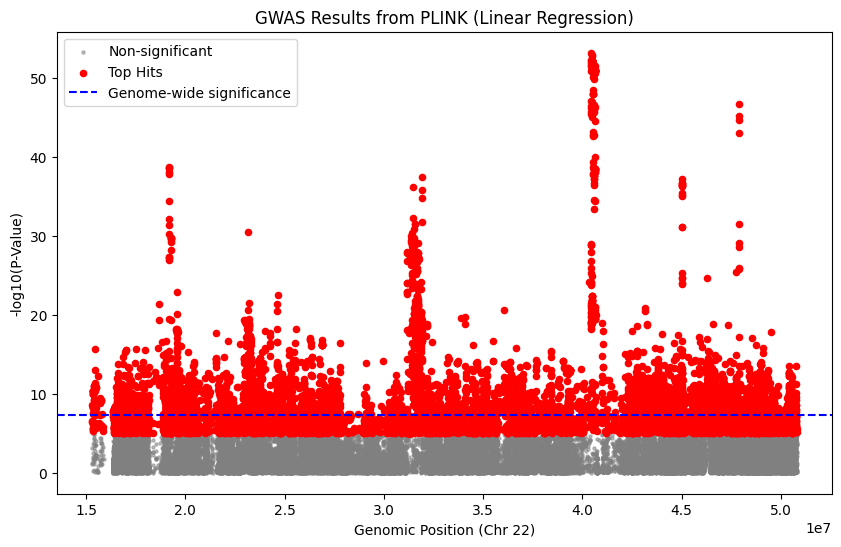

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_plink = pd.read_csv("data/my_gwas_results.assoc.linear", delim_whitespace=True)

df_plink = df_plink[df_plink['TEST'] == 'ADD']

plt.figure(figsize=(10, 6))

plt.scatter(df_plink['BP'], -np.log10(df_plink['P']), s=5, color='gray', alpha=0.5, label='Non-significant')

top_hits = df_plink[df_plink['P'] < 1e-5]
plt.scatter(top_hits['BP'], -np.log10(top_hits['P']), s=20, color='red', label='Top Hits')

plt.title("GWAS Results from PLINK (Linear Regression)")
plt.xlabel("Genomic Position (Chr 22)")
plt.ylabel("-log10(P-Value)")
plt.axhline(y=-np.log10(5e-8), color='blue', linestyle='--', label='Genome-wide significance') 
plt.legend()
plt.show()

In [92]:
true_causal_snps = bim.iloc[idx_caus]['snp'].values

print(true_causal_snps)

checks = df_plink[df_plink['SNP'].isin(true_causal_snps)]
print(checks[['SNP', 'BETA', 'P']].sort_values('P'))

<StringArray>
[ 'rs2800958',  'rs1555189',  'rs4642034', 'rs73167089',  'rs5753820',
  'rs4820983',  'rs2071723', 'rs67966911',  'rs9612248',  'rs5766921']
Length: 10, dtype: string
              SNP     BETA             P
39099  rs73167089 -0.82170  9.107000e-53
51289   rs5766921 -0.54490  6.840000e-46
46229   rs1555189 -0.39820  5.202000e-26
25866   rs4820983  0.30170  7.919000e-21
26215   rs5753820  0.21470  2.867000e-09
5626   rs67966911  0.40530  2.122000e-08
12035   rs9612248  0.15960  1.521000e-06
5134    rs2800958 -0.11290  6.540000e-04
5331    rs4642034  0.09112  5.302000e-03
41659   rs2071723  0.02933  4.049000e-01
